In [15]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

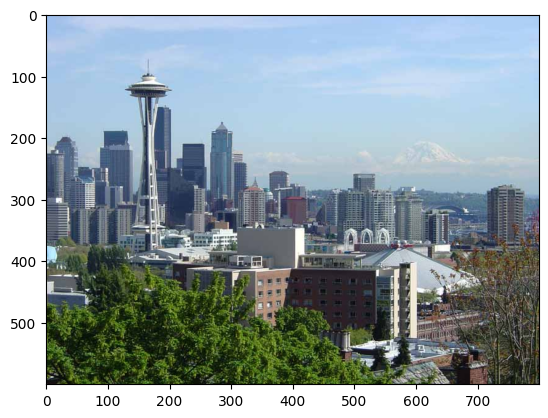

In [16]:
image = Image.open('Seattle.jpg')
image = np.asarray(image)
plt.imshow(image)

Gaussian filter = $$ G(\mathbf{x}; \sigma^2) = \frac{1}{2 \pi \sigma^2} \exp{-\frac{\mathbf{x}^T \mathbf{x}}{2 \sigma^2}}$$

0.9999293


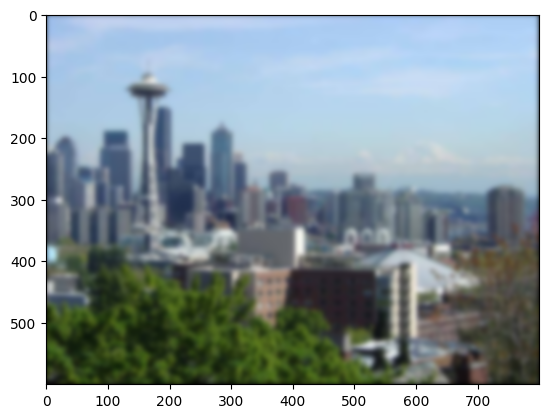

In [17]:
# Problem 1

def convolution(image, filter): #Code from discussion
    img_filtered = np.zeros_like(image, dtype=np.float32)
    yfsize, xfsize = filter.shape
    ypadding = (yfsize - 1) // 2
    xpadding = (xfsize - 1) // 2
    img_pad = np.pad(image, pad_width=((ypadding, ypadding), (xpadding, xpadding)), mode = 'constant', constant_values = 0)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            img_sub = img_pad[i:i + yfsize, j:j + xfsize]
            img_filtered[i][j] = (img_sub * filter).sum()

    return img_filtered


def GaussianBlurImage(image, sigma):
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter = np.zeros((filter_size, filter_size), np.float32)
    for i in range(filter_size):
        for j in range(filter_size):
            x = i - filter_size // 2
            y = j - filter_size // 2
            gaussian_filter[i, j] = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(x ** 2 + y ** 2)/(2 * sigma ** 2))
    print(gaussian_filter.sum())

    im_filtered = np.zeros_like(image, dtype=np.float32)
    for c in range(3):
        im_filtered[:, :, c] = convolution(image[:, :, c], gaussian_filter)

    return im_filtered

filtered = GaussianBlurImage(image, 4)
plt.imshow(np.clip(filtered, 0, 255).astype(np.uint8))
plt.imsave('1.png', filtered.astype(np.uint8))

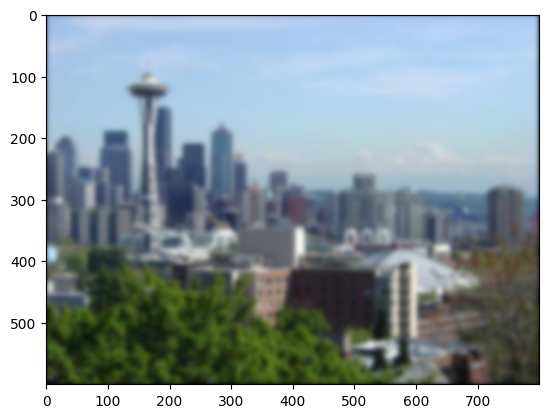

In [18]:
# Problem 2

def SeparableGaussian(image, sigma):
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter_horizontal = np.zeros((1, filter_size), np.float32)
    gaussian_filter_vertical = np.zeros((filter_size, 1), np.float32)
    a = filter_size // 2
    b = filter_size // 2
    
    for x in range(-a, a):
        x1 = np.sqrt(2 * np.pi * sigma ** 2)
        x2 = np.exp(-(x ** 2) / (2 * sigma ** 2))
        gaussian_filter_vertical[x + a, :] = (1 / x1) * x2

    for y in range(-b, b + 1):
        y1 = np.sqrt(2 * np.pi * (sigma ** 2))
        y2 = np.exp(-(y ** 2) / (2 * sigma ** 2))
        gaussian_filter_horizontal[:, y + b] = (1 / y1) * y2
            
    im_filtered = np.zeros_like(image, dtype = np.float32)
    
    for i in range(3):
        im_filtered[:, :, i] = convolution(image[:, :, i], gaussian_filter_horizontal)
        
    for i in range(3):
        im_filtered[:, :, i] = convolution(im_filtered[:, :, i], gaussian_filter_vertical)

    return im_filtered

filtered = SeparableGaussian(image, 4)

plt.imshow(np.clip(filtered, 0, 255).astype(np.uint8))
plt.imsave("2.png", filtered.astype(np.uint8))

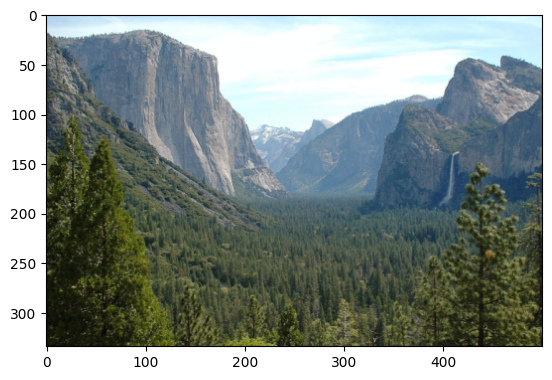

In [19]:
image2 = Image.open('Yosemite.png')
image2 = np.asarray(image2)
plt.imshow(image2)

0.99999404


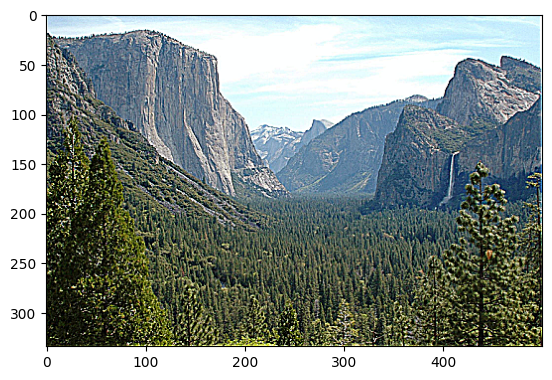

In [20]:
# Problem 3

def SharpenImage(image, sigma, alpha):
    smooth_brain = GaussianBlurImage(image, sigma)
    sharpen = image - alpha * (smooth_brain - image)
    clipped_filtered = np.clip(sharpen, 0, 255).astype(np.uint8)
    return clipped_filtered

filtered = SharpenImage(image2, 1, 5)
plt.imshow(filtered)
plt.imsave('4.png', filtered)

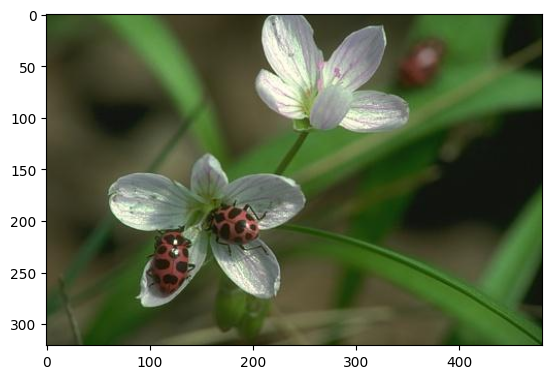

In [21]:
image3 = Image.open('LadyBug.jpg')
image3 = np.asarray(image3)
plt.imshow(image3)

In [22]:
#Problem 4

def SobelImage(image):
    image = Image.open(image).convert('L')
    image = np.asarray(image)
    
    X = convolution(image, np.array([[-1,0,1],[-2,0,2],[-1,0,1]]))
    Y = convolution(image, np.array([[-1,-2,-1],[0,0,0],[1,2,1]]))
    
    m = np.sqrt(X ** 2 + Y ** 2)
    o = np.arctan2(Y , X)
    
    return (m, o)

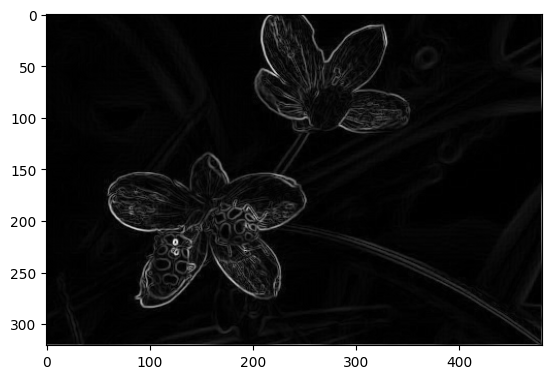

In [23]:
image5a = SobelImage("LadyBug.jpg")[0]
plt.imshow(image5a, cmap = "gray")
plt.imsave("5a.png", image5a, cmap ="gray")

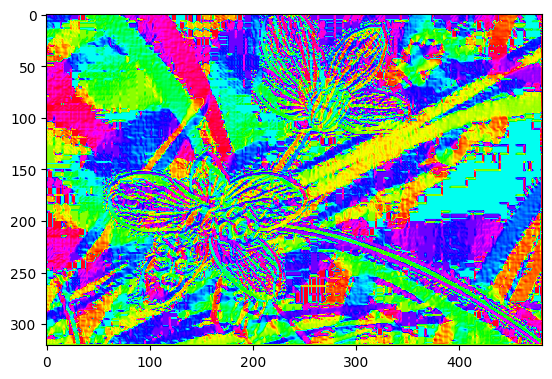

In [24]:
image5b = SobelImage("LadyBug.jpg")[1]
plt.imshow(image5b, cmap = plt.cm.hsv)
plt.imsave("5b.png", image5b, cmap = plt.cm.hsv)

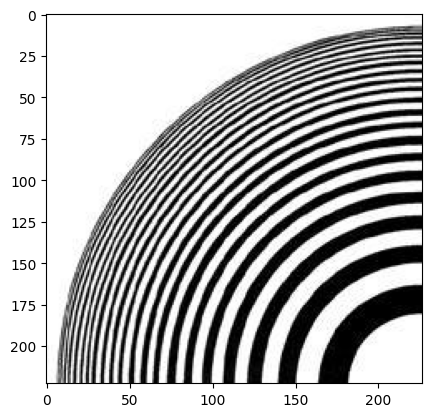

In [25]:
image6 = Image.open("Moire_small.jpg")
image6 = np.array(image6).astype(np.uint8)
plt.imshow(image6)

In [26]:
# Problem 5

def NNInterpolation(image, x, y):
    x_nearest = int(round(x))
    y_nearest = int(round(y))

    pixel_value = image[y_nearest, x_nearest]
    return pixel_value

def BilinearInterpolation(image, x, y):
    h, w = image.shape[:2]

    x1 = int(np.floor(x))
    x1 = np.clip(x1, 0, w - 1)
    x2 = x1 + 1
    x2 = np.clip(x2, 0, w - 1)
    y1 = int(np.floor(y))
    y1 = np.clip(y1, 0, h - 1)
    y2 = y1 + 1
    y2 = np.clip(y2, 0, h - 1)

    q11 = image[y1, x1]
    q12 = image[y2, x1]
    q21 = image[y1, x2]
    q22 = image[y2, x2]
 
    a = x - x1
    b = y - y1
    
    pixel_value = (1 - a) * (1 - b) * q11 + a * (1 - b) * q21 + (1 - a) * b * q12 + a * b * q22
    
    return pixel_value

def UpSampling(image, factor, interpolation):
    height, width = image.shape[:2]

    new_height = height * factor 
    new_width = width * factor

    upsampled_image = np.zeros((new_height, new_width, image.shape[2]), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            x = j / factor
            y = i / factor

            x = np.clip(x, 0, width - 1)
            y = np.clip(y, 0, height - 1)
            
            if interpolation == "Bilinear":
                upsampled_image[i][j] = BilinearInterpolation(image, x, y)
            else:
                upsampled_image[i][j] = NNInterpolation(image, x, y)
    
    return upsampled_image


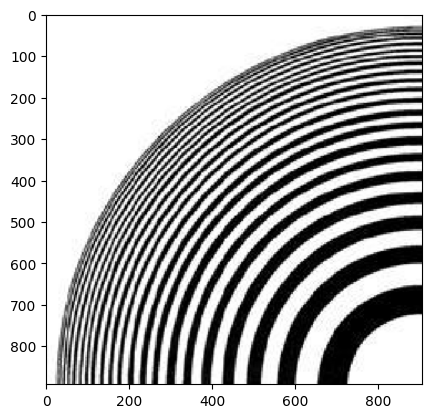

In [27]:
# Upsample the image with nearest neighbor interpolation and save it as "6a.png"
image_upsampled_nn = UpSampling(image6, factor = 4, interpolation="NNInterpolation")
plt.imshow(np.clip(image_upsampled_nn, 0, 255).astype(np.uint8))
plt.imsave("6a.png", image_upsampled_nn.astype(np.uint8))

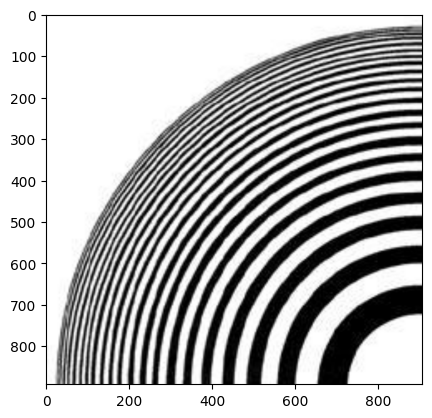

In [28]:
# Upsample the image with bilinear interpolation and save it as "6b.png"
image_upsampled_bilinear = UpSampling(image6, 4, interpolation = "Bilinear")
plt.imshow(np.clip(image_upsampled_bilinear, 0, 255).astype(np.uint8))
plt.imsave("6b.png", image_upsampled_bilinear.astype(np.uint8))

WRITTEN SECTION

1. (10 points) What is the best amount of blur to apply when down-sampling Moire.jpg by 8x (pressing “Half Size” 3 times)? Does down-sampling “Seattle.jpg” require the same amount of blur?

The ideal amount of blur depends on the image content and the specific down-sampling factor. For Moire.jpg, you are down-sampling by a factor of 8 (pressing "Half Size" 3 times: 1/2 * 1/2 * 1/2 = 1/8). A suitable blur radius can be calculated, in our case, by using the guassian blur function and down sampling it. For Moire image, I would use sigma 3. For the Seattle image, I would use sigma 5. Using a lower sigma on this image would cause artifacting.


2. (10 points) If you rotate the image 20 times by 2 degrees, does it produce the same result as rotating
the image by 40 degrees? If not, why? You may use ”imrotate” command in Matlab.

When you rotate an image 20 times by 2 degrees, it doesn't give you the same result as rotating it once by 40 degrees. This difference happens because of the errors that build up during the interpolation process with each rotation. As you rotate an image, the pixel values get resampled using interpolation methods like nearest-neighbor, bilinear, or bicubic. This means the new pixel values are estimated based on the original ones. When you keep rotating the image multiple times, the interpolation happens again and again, which can slowly degrade the image quality and cause errors to add up. In contrast, if you rotate the image just once with a larger angle, like 40 degrees, the interpolation only occurs one time. This leads to fewer errors and usually helps maintain the image quality better.